# Week7

## Part 2: Community detection

For example if you open the page for The Rolling Stones, you'll see that it contains info about their place of origin, the genres of music they've been associated with (in the case of the Stones it's rock, pop and blues), their year's active, the record labels they've signed with over time, etc. All really interesting information if we want to understand the network of artists.

So let's start with an exercise designed to give you a sense of how good the LLMs are at the whole text-parsing thing.

**Exercise: Go nuts with an LLM and get all the genres for the nodes in your network**

- Yes, I'm serious. For this one I'd like you to fire up your most powerful thinking model you have access to and get it to write a script to extract genre for all nodes in your network. Some notes to help you
If the node doesn't have an infobox (or if a node's infobox doesn't have a genre it it), just don't assign that node a genre and ignore it in the downstream analysis
Remember to lowercase all genres, also consider simplifying things by mapping rock'n'roll, rock & roll, etc to a single genre.
Remember to test your algorithm well before emplying it, since you're not writing the code yourself, you need to work harder to prove to yourself that it's actually doing what you think it's doing. You should inspect the code to understand what it's actually doing and also test it on the strangest edge-cases you can find. (Can it handle, "The Animals", for example).
The output should be a dictionary mapping artist names to lists of genres (since most artists have multiple genres listed).
- Report the following stats
  - The number of nodes for which you could find genres
  - The average number of genres per node
  - The total number of distinct genres
  - A histogram showing artist counts for the top 15 genres

In [79]:
import re
import html

def extract_genres_from_wikitext(wikitext_content):
    """
    Extract a cleaned, normalized list of genres from Wikipedia-like wikitext.
    - Removes refs, citation templates, wrapper templates, HTML, and wiki links.
    - Strips all parenthetical qualifiers (e.g., '(early)', '(late)') and broken tails.
    - Lowercases all genres.
    - Normalizes common variants (rock & roll, r&b, hip-hop, post punk, synth pop, etc.).
    - Drops obvious template/config noise.
    - Deduplicates while preserving order.
    """
    # 1) Isolate the 'genre =' field in the infobox
    m = re.search(
        r'\|\s*genre\s*=\s*(.*?)(?=\n\s*\||\n}})',
        wikitext_content,
        flags=re.DOTALL | re.IGNORECASE
    )
    if not m:
        return []
    g = m.group(1)

    # 2) Decode HTML entities (&lt;ref&gt; -> <ref>, &amp; -> &, etc.)
    g = html.unescape(g)

    # 3) Remove HTML comments
    g = re.sub(r'<!--.*?-->', '', g, flags=re.DOTALL)

    # 4) Remove references: self-closing BEFORE paired to avoid cross-line capture
    g = re.sub(r'<ref[^>]*/>', '', g, flags=re.DOTALL | re.IGNORECASE)                      # <ref .../>
    g = re.sub(r'<ref(?:(?!/>)[^>])*?>.*?</ref>', '', g, flags=re.DOTALL | re.IGNORECASE)   # <ref ...>...</ref>

    # 5) Remove citation/footnote templates entirely
    g = re.sub(r'\{\{\s*cite[^{}]*\}\}', '', g, flags=re.IGNORECASE)                        # {{cite web|...}}
    g = re.sub(r'\{\{\s*harv-?nb?[^{}]*\}\}', '', g, flags=re.IGNORECASE)                   # {{harvnb}}, {{harv-nb}}
    g = re.sub(r'\{\{\s*(sfn|sfnb|efn|refn)[^{}]*\}\}', '', g, flags=re.IGNORECASE)         # {{sfn}}, {{refn}}, etc.
    g = re.sub(r'\{\{\s*(citation needed|cn)[^{}]*\}\}', '', g, flags=re.IGNORECASE)        # {{citation needed}}, {{cn}}

    # 6) Drop wrapper templates but keep their inner content
    g = re.sub(r'\{\{\s*(flatlist|hlist|nowrap|plainlist|ubl|unbulleted list)\s*\|?', '',
               g, flags=re.IGNORECASE)

    # 7) Remove remaining braces and HTML tags like <small>, <i>, etc.
    g = g.replace('{{', '').replace('}}', '')
    g = re.sub(r'<[^>]+>', '', g)

    # 8) Replace wiki links [[A|B]] -> B; [[A]] -> A
    g = re.sub(r'\[\[(?:[^|\]]+\|)?([^\]]+)\]\]', r'\1', g)

    # 9) Normalize whitespace (incl. NBSP) and bullets
    g = g.replace('\xa0', ' ')
    g = g.replace('*', ' ')

    # 10) Split on common delimiters
    parts = re.split(r'[\n,;•·]+|\s*\|\s*', g)

    # --- Normalization helpers ---

    # Canonical mapping for near-duplicates and synonyms (all keys/values lowercase)
    CANON_MAP = {
        # rock and roll family
        "rock & roll": "rock and roll",
        "rock and roll": "rock and roll",
        "rock 'n' roll": "rock and roll",
        "rock ’n’ roll": "rock and roll",
        "rock `n` roll": "rock and roll",

        # r&b / rhythm & blues
        "r&b": "rhythm and blues",
        "r & b": "rhythm and blues",
        "rhythm & blues": "rhythm and blues",

        # hip hop
        "hip-hop": "hip hop",
        "hip–hop": "hip hop",

        # hyphen/space variants
        "post punk": "post-punk",
        "synth pop": "synth-pop",
        "dance rock": "dance-rock",
        "blue eyed soul": "blue-eyed soul",

        # AOR
        "aor": "album-oriented rock",
    }

    # Regexes for pattern families
    ROCKNROLL_RX = re.compile(r"rock\s*(?:&|and|['`´’]\s*n['`´’])\s*roll")
    HIPHOP_RX    = re.compile(r"hip\s*[-–]?\s*hop")
    RAND_B_RX    = re.compile(r"(?:^|\b)r\s*&\s*b(?:\b|$)|rhythm\s*&\s*blues")

    # Token acceptability: letters (incl. accents), numbers, space, hyphen, apostrophes/quotes, ampersand, dots
    ALLOWED_RX   = re.compile(r"^[0-9A-Za-zÀ-ÖØ-öø-ÿ\s\-\&'`´’\.]+$")

    # Substrings indicating template/config noise to drop
    DROP_SUBSTRS = [
        'citation', 'cite', 'access-date', 'archive-url', 'archive-date',
        'publisher=', 'website=', 'title=', 'url=', 'first=', 'last=',
        'class=', 'nowrap', 'italic', 'lang', 'script=', 'format='
    ]

    def normalize_label(t: str) -> str:
        # Trim punctuation
        t = t.strip()
        t = re.sub(r'^[\W_]+|[\W_]+$', '', t)
        if not t:
            return ''

        # Drop obvious noise
        lo = t.lower()
        if any(s in lo for s in DROP_SUBSTRS):
            return ''

        # Remove any parenthetical parts, even if multiple (e.g., "(early)", "(later)")
        t = re.sub(r'\s*\([^)]*\)', '', t).strip()
        # If an unmatched '(' tail remains, drop that too (e.g., "funk metal (early")
        t = re.sub(r'\s*\([^)]*$', '', t).strip()

        # Lowercase
        t = t.lower()

        # Normalize rock and roll forms
        if ROCKNROLL_RX.search(t):
            t = ROCKNROLL_RX.sub('rock and roll', t)

        # Normalize hip hop forms
        if HIPHOP_RX.search(t):
            t = HIPHOP_RX.sub('hip hop', t)

        # Normalize r&b / rhythm & blues
        if RAND_B_RX.search(t):
            t = 'rhythm and blues'

        # Apply canonical map (covers aor, synth-pop, post-punk, blue-eyed soul, dance-rock, etc.)
        t = CANON_MAP.get(t, t)

        # Reject invalid tokens (after normalization)
        if not ALLOWED_RX.match(t):
            return ''

        # Collapse repeated spaces and strip stray punctuation
        t = re.sub(r'\s{2,}', ' ', t).strip('. ').strip()

        return t

    cleaned = [normalize_label(p) for p in parts]
    cleaned = [c for c in cleaned if c]

    # Deduplicate while preserving order (already lowercase)
    out, seen = [], set()
    for x in cleaned:
        if x not in seen:
            seen.add(x)
            out.append(x)
    return out

In [80]:
# Define the directory where your band data files are located
data_directory = "Bands"
band_genres = {}

# Iterate over all files in the specified directory
for filename in os.listdir(data_directory):
    file_path = os.path.join(data_directory, filename)
    band_name = os.path.splitext(filename)[0] # Get band name from filename

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()

            wikitext_content = content

            genres = extract_genres_from_wikitext(wikitext_content)
            band_genres[band_name] = genres
    except Exception as e:
        print(f"Error processing file {filename}: {e}")

# order the band list alphabetically
band_genres = dict(sorted(band_genres.items()))

'''
# print number of bands that have infoboxes:
num_bands_with_infoboxes = sum(1 for genres in band_genres.values() if genres)
print(f"Number of bands with infoboxes: {num_bands_with_infoboxes} \n")

# Print the extracted genres for each band
for band, genres in band_genres.items():
    print(f"{band}: {genres}")
'''

'\n# print number of bands that have infoboxes:\nnum_bands_with_infoboxes = sum(1 for genres in band_genres.values() if genres)\nprint(f"Number of bands with infoboxes: {num_bands_with_infoboxes} \n")\n\n# Print the extracted genres for each band\nfor band, genres in band_genres.items():\n    print(f"{band}: {genres}")\n'

The output should be a dictionary mapping artist names to lists of genres (since most artists have multiple genres listed).
- Report the following stats
  - The number of nodes for which you could find genres
  - The average number of genres per node
  - The total number of distinct genres
  - A histogram showing artist counts for the top 15 genres

=== Genre Extraction Stats ===
Number of bands/nodes with genres: 472
Average number of genres per band/node: 3.98
Total number of distinct genres: 203

Top genres by artist count:
alternative rock: 143
hard rock: 143
pop rock: 104
rock: 83
alternative metal: 62
blues rock: 57
pop: 53
heavy metal: 52
post-grunge: 46
soft rock: 42
indie rock: 36
new wave: 33
progressive rock: 32
art rock: 30
folk rock: 30


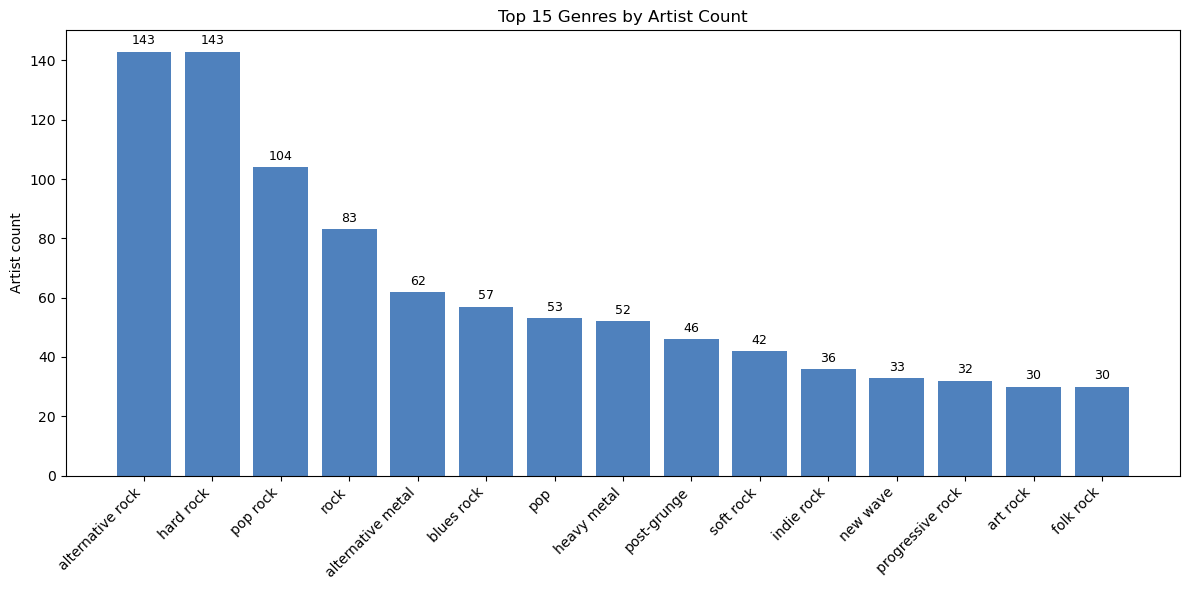

In [81]:
from collections import Counter, defaultdict
import math
import matplotlib.pyplot as plt

# --- 1) Basic stats ---

# Artists with at least one genre
artists_with_genres = {artist: genres for artist, genres in band_genres.items() if genres}

num_nodes_with_genres = len(artists_with_genres)

# Average number of genres per node (considering only nodes that have >= 1 genre)
if num_nodes_with_genres > 0:
    avg_genres_per_node = sum(len(g) for g in artists_with_genres.values()) / num_nodes_with_genres
else:
    avg_genres_per_node = float('nan')

# Distinct genres across all artists
all_genres = [g for genres in artists_with_genres.values() for g in genres]
distinct_genres = set(all_genres)
num_distinct_genres = len(distinct_genres)

print("=== Genre Extraction Stats ===")
print(f"Number of bands/nodes with genres: {num_nodes_with_genres}")
print(f"Average number of genres per band/node: {avg_genres_per_node:.2f}" if not math.isnan(avg_genres_per_node) else
      "Average number of genres per band/node: N/A (no nodes with genres)")
print(f"Total number of distinct genres: {num_distinct_genres}")

# --- 2) Top-15 genres histogram (by artist counts) ---

# Count per genre: number of **artists** associated to that genre
# (ensures an artist counted only once per genre even if duplicates slipped in)
genre_to_artists = defaultdict(set)
for artist, genres in artists_with_genres.items():
    for g in set(genres):  # set() to be safe against accidental duplicates
        genre_to_artists[g].add(artist)

genre_counts = Counter({g: len(artist_set) for g, artist_set in genre_to_artists.items()})

top_n = 15
top15 = genre_counts.most_common(top_n)

print("\nTop genres by artist count:")
for g, c in top15:
    print(f"{g}: {c}")

# Plot
if top15:
    genres_plot, counts_plot = zip(*top15)
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(genres_plot)), counts_plot, color="#4F81BD")
    plt.xticks(range(len(genres_plot)), genres_plot, rotation=45, ha='right')
    plt.ylabel("Artist count")
    plt.title(f"Top {top_n} Genres by Artist Count")
    # Add value labels on bars
    for bar, val in zip(bars, counts_plot):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts_plot)*0.01,
                 str(val), ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No genres to plot for histogram (top15 is empty).")

-------

Now that we have the genres, let’s use them - and see how community-like the community is, if we consider the genres to be community labels.

**Exercise: Use the concept of modularity to explore how community-like the genres are.**

- Explain the concept of modularity in your own words.

Work from the undirected version of the network, keeping only the nodes for which you have genre information.
- Now create your own partition of the network into genres.
- Each node is simply characterized by the first genre in its list of genres.
- Each community is the group of nodes that share the same genre.
- That’s all you need, now calculate the modularity of this division of the network into genres.

Note: Modularity is described in the Network Science book, section 9.4.. Thus, use equation 9.12 in the book to calculate the modularity 
 of the partition described above. Are the genres good communities?

- Thinking a bit about the underlying data, a potential issue is the following: Many artists have the genre rock as their first genre in the list (since we started from a list of rock bands). So if rock is a big community, the network won’t have very high modularity.
- What happens to the modularity if you use a random genre from the list genre as the node-label for those nodes with more than one genre listed?
- Discuss your findings - and decide how you want to settle on a single genre for each band.

**Explain the concept of modularity in your own words.**

**Work from the undirected version of the network, keeping only the nodes for which you have genre information.**
- Now create your own partition of the network into genres.
- Each node is simply characterized by the first genre in its list of genres.
- Each community is the group of nodes that share the same genre.
- That’s all you need, now calculate the modularity of this division of the network into genres.

Note: Modularity is described in the Network Science book, section 9.4.. Thus, use equation 9.12 in the book to calculate the modularity 
 of the partition described above. Are the genres good communities?

Creating the graph

In [82]:
import networkx as nx

# Create an empty graph
G_artists = nx.Graph()

# Add nodes to the graph from the artists_with_genres
# The keys of the dictionary are the artist names (nodes)
# The values are the lists of genres (attributes)
for artist, genres in artists_with_genres.items():
    G_artists.add_node(artist, genres=genres)

print(f"Created a graph with {G_artists.number_of_nodes()} nodes.")

# print first 5 nodes
print("First 5 nodes in the graph with their genres:")
for i, (node, data) in enumerate(G_artists.nodes(data=True)):
    if i >= 5:
        break
    print(f"{node}: {data['genres']}")

Created a graph with 472 nodes.
First 5 nodes in the graph with their genres:
10_Years__band_: ['alternative metal', 'progressive metal', 'post-grunge', 'nu metal']
10cc: ['art rock', 'art pop', 'progressive pop', 'soft rock', 'pop rock']
311__band_: ['alternative rock', 'rap rock', 'reggae rock', 'funk rock', 'funk metal']
38_Special__band_: ['hard rock', 'southern rock', 'boogie rock', 'blues rock']
3_Doors_Down: ['post-grunge', 'hard rock', 'alternative rock']


Now we will add the links, by using the graph used for assignment 1

In [83]:
# import link list from rock_music_graph.graphml
G_links = nx.read_graphml(r"/Users/noa/Desktop/02805 - Social Graphs/SocialGraphs/Assignment1/rock_music_graph.graphml")
# remove Allmusic node
if 'Allmusic' in G_links:
    G_links.remove_node('Allmusic')

# clean artists names to match
def sanitize_filename(name):
    # Replace any char that is a "(,),/,\,?,%,*,:,|,",<,>,., " " with underscore
    return re.sub(r'[()\/\\\?%*:|<>.\s]', '_', name)

# sanitize node names in G_links to match
mapping = {node: sanitize_filename(node) for node in G_links.nodes()}
G_links = nx.relabel_nodes(G_links, mapping)
# save cleaned link graph
nx.write_graphml(G_links, r"/Users/noa/Desktop/02805 - Social Graphs/SocialGraphs/Noa/Bands_graph.graphml")

print(f"Imported link graph with {G_links.number_of_nodes()} nodes and {G_links.number_of_edges()} edges.")

# --- Now we can proceed to add edges to G_artists based on G_links ---
G = G_artists.copy()

for u, v in G_links.edges():
    if G.has_node(u) and G.has_node(v):
        G.add_edge(u, v)

# NOTE: G is now our final graph with genres as node attributes and the links are the original links from Assignment 1
'''
for n, data in G.nodes(data=True):
    for k, v in list(data.items()):
        if isinstance(v, (list, dict, set, tuple)):
            G.nodes[n][k] = str(v)  # convert to plain string

for u, v, data in G.edges(data=True):
    for k, v in list(data.items()):
        if isinstance(v, (list, dict, set, tuple)):
            G.edges[u, v][k] = str(v)
nx.write_graphml(G, r"/Users/noa/Desktop/02805 - Social Graphs/SocialGraphs/Noa/Bands_with_genres.graphml")
'''

print(f"The final graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


Imported link graph with 473 nodes and 7452 edges.
The final graph has 472 nodes and 5569 edges.


Plotting the graph

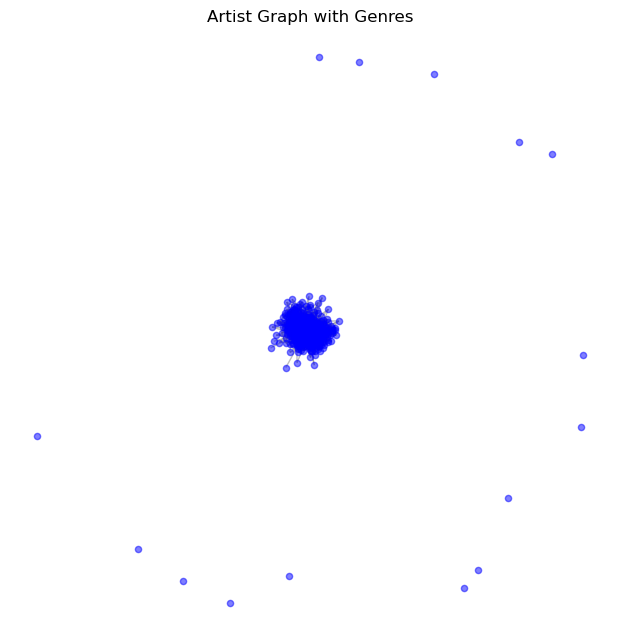

In [84]:
# plot graph
plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G, seed=42)  # positions for all nodes
nx.draw(G, pos, node_size=20, node_color='blue', edge_color='gray', alpha=0.5)
plt.title("Artist Graph with Genres")
plt.show()

Remove nodes with no links

Removed 15 nodes with no links. The graph now has 457 nodes.


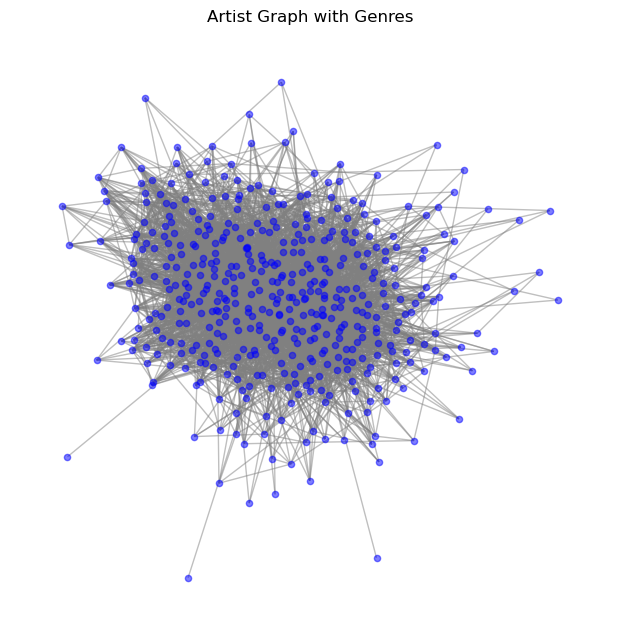

In [85]:
# Remove nodes with no links
nodes_to_remove = [node for node in G.nodes() if G.degree(node) == 0]
G.remove_nodes_from(nodes_to_remove)
print(f"Removed {len(nodes_to_remove)} nodes with no links. The graph now has {G.number_of_nodes()} nodes.")

plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G, seed=42)  # positions for all nodes
nx.draw(G, pos, node_size=20, node_color='blue', edge_color='gray', alpha=0.5)
plt.title("Artist Graph with Genres")
plt.show()

**Now create your own partition of the network into genres.**
- Each node is simply characterized by the first genre in its list of genres.
- Each community is the group of nodes that share the same genre.

In [86]:
from collections import defaultdict

# Each node is assigned to the community of its first listed genre
communities_by_genre = defaultdict(list)
for node, data in G.nodes(data=True):
    genres = data.get('genres')
    if genres:
        first_genre = genres[0]
        communities_by_genre[first_genre].append(node)

# a list of sets (the communities).
partition = [set(nodes) for nodes in communities_by_genre.values()]
print(f"\nCreated a partition with {len(partition)} communities based on the first genre.")


Created a partition with 77 communities based on the first genre.


- That’s all you need, now calculate the modularity of this division of the network into genres.
- Thus, use equation 9.12 in the book to calculate the modularity of the partition described above. Are the genres good communities?

In [87]:
def modularity(G, partition):
    """
    Compute modularity using Eq. 9.12:

    Args:
        G: networkx Graph (undirected)
        partition: list of sets of nodes (each set = community)
    Returns:
        float modularity
    """
    L = G.number_of_edges()  # total edges
    degrees = dict(G.degree())

    M = 0.0
    for community in partition:
        # Internal edges in community
        L_c = G.subgraph(community).number_of_edges()
        # Sum of degrees in community
        k_c = sum(degrees[node] for node in community)
        M += (L_c / L) - (k_c / (2 * L)) ** 2

    return M

# Calculate and report the modularity 
mod = modularity(G, partition)
print(f"Modularity (Eq. 9.12): {mod:.4f}")

Modularity (Eq. 9.12): 0.0944


**Are the genres good communities?**

A score near or below zero indicates the partitioning is no better than random.

The modularity of this partition is: 0.0944 indicating that the genres do not form strong communities.

**Exercise**
- Thinking a bit about the underlying data, a potential issue is the following: Many artists have the genre rock as their first genre in the list (since we started from a list of rock bands). So if rock is a big community, the network won’t have very high modularity.
- What happens to the modularity if you use a random genre from the list genre as the node-label for those nodes with more than one genre listed?
- Discuss your findings - and decide how you want to settle on a single genre for each band.

In [88]:
# number of nodes that has Rock as their first genre
rock_community_size = len(communities_by_genre.get('rock', []))
print(f"\nNumber of nodes with 'rock' as their first genre: {rock_community_size}")
print(f"This is approx {((rock_community_size / G.number_of_nodes()) * 100):.2f}% of the total nodes.")


Number of nodes with 'rock' as their first genre: 68
This is approx 14.88% of the total nodes.


In [89]:
import random

random.seed(42)

communities_by_genre_rand = defaultdict(set)

for node, data in G.nodes(data=True):
    genres = data.get('genres') or []
    if not genres:
        continue
    chosen = random.choice(genres)  # uniform random choice among available genres
    communities_by_genre_rand[chosen].add(node)

# Remove empty sets and return as list of sets
partition_rand = [nodes for nodes in communities_by_genre_rand.values() if nodes]

M_rand = modularity(G, partition_rand)
print(f"Random-genre partition modularity (single draw): {M_rand:.4f}")

Random-genre partition modularity (single draw): 0.0365


**Discuss your findings - and decide how you want to settle on a single genre for each band.**

The modality is now lower

**CHAT SVAR**
Genres as communities are weak overall
Both modularity values are low (well below 0.3, which is often considered strong community structure). This means the network’s connectivity does not strongly align with genre labels.


First genre performs better than random
The modularity for the first-genre partition is more than double the random assignment (0.0944 vs. 0.0365). This suggests that the first genre in the list is not arbitrary—it captures some real structure, but still weak.


Interpretation

Genres are not perfect predictors of network connectivity.
Multi-genre nodes introduce ambiguity: picking randomly dilutes structure further.
The improvement from random to first genre implies some consistency in how genres are ordered (likely the primary genre is listed first).


**Exercise: Community detection to find structral communities in the network**

- Again, work only with the subnetwork of nodes that have at least one genre.
- Use the Louvain-algorithm to find communities for the network. Report the value of modularity found by the algorithm.
- What is the modularity of this partitioning of the network? Is it more community-like than the genres? What does this comparison reveal about the communities?
- Visualize the network, using the Force Atlas algorithm.
- This time assign each node a different color based on its structural community.
- Note: If there's a lot of small communities, it's OK to only color the 5-10 largest communities (you can make the remaing nodes light gray or some netural color)
- Describe the structure you observe.
- Keep using the community labels from above, but now visualize only the backbone-edges from your favorite network backbone from last week. - - Do the community correspond to the backbone structure you detected?

In [110]:
#using networkx louvain_communities to find communities
louvain_communities = list(nx.community.louvain_communities(G, seed=11))
louvain_modularity = nx.community.modularity(G, louvain_communities)
print(f"\nLouvain method found {len(louvain_communities)} communities with a modularity of {louvain_modularity:.4f}.")


Louvain method found 5 communities with a modularity of 0.3390.


**What is the modularity of this partitioning of the network? Is it more community-like than the genres? What does this comparison reveal about the communities?**

Yes this partitioning is much more community-like, as the moduality is higher. 

This means that the gerne that the band has as the first in their bio and the linking between them doesn't have a community structure

**Exercise**
- Visualize the network, using the Force Atlas algorithm.
- This time assign each node a different color based on its structural community.
- Note: If there's a lot of small communities, it's OK to only color the 5-10 largest communities (you can make the remaing nodes light gray or some netural color)

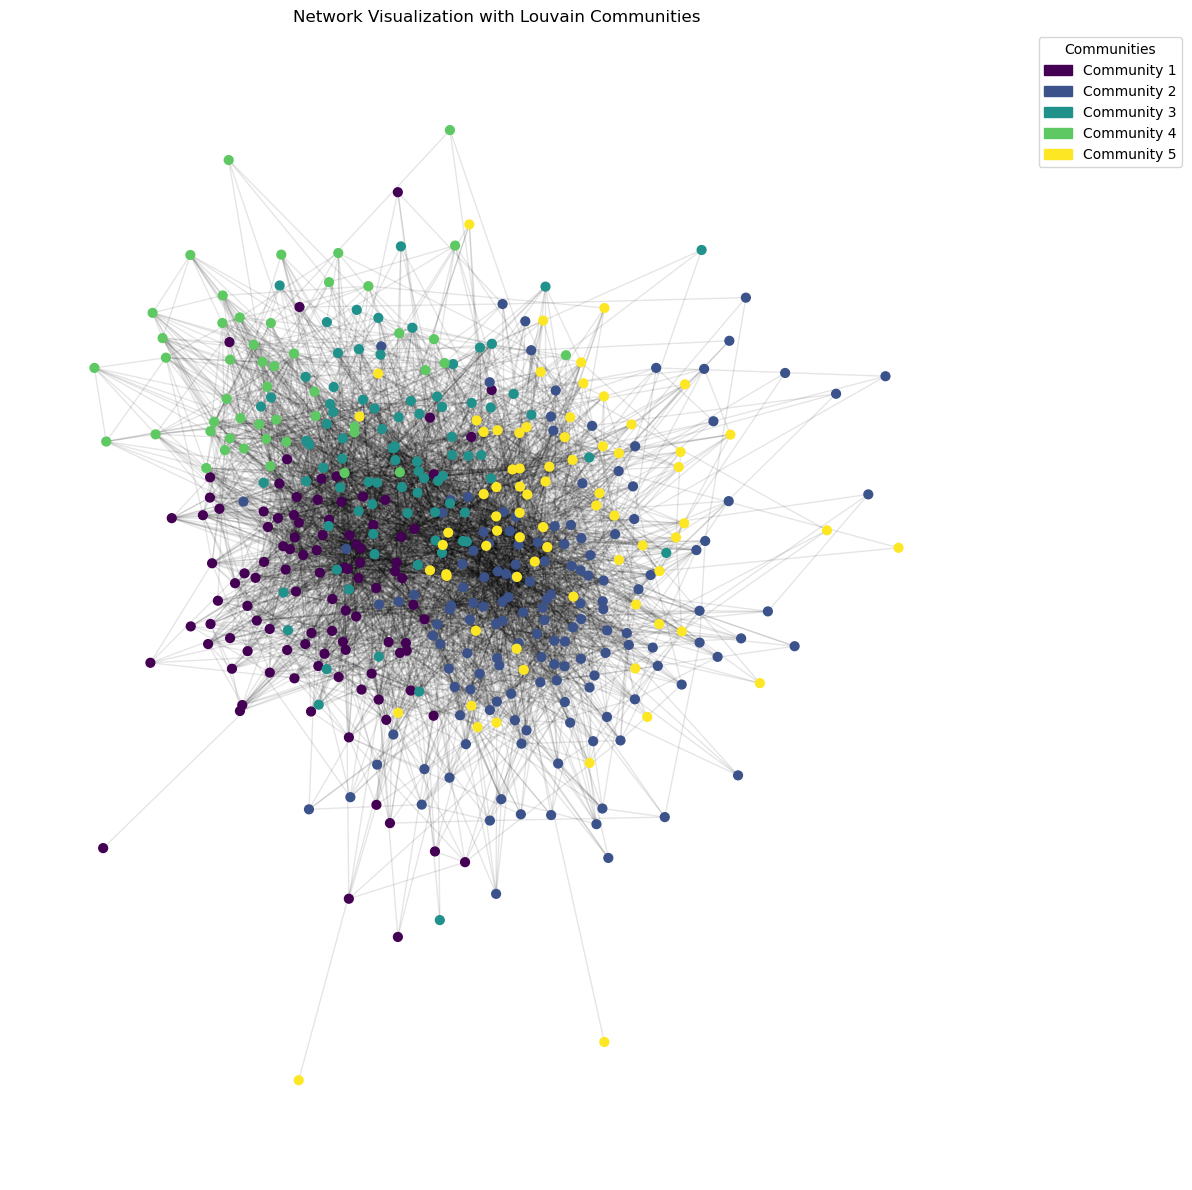

In [111]:
from matplotlib.patches import Patch

# visualize the network using the Force Atlas algorithm with communities colored differently

# using louvain_communities
partition = {}
for i, community in enumerate(louvain_communities):
    for node in community:
        partition[node] = i


# Set the size of the plot
plt.figure(figsize=(12, 12))
# Compute the layout using spring layout (Force Atlas-like)
pos = nx.spring_layout(G, seed=42)
# Draw nodes with colors based on their community
cmap = plt.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.1)
# We will create custom legend handles because networkx doesn't do it automatically
legend_handles = []
for i in range(len(louvain_communities)):
    legend_handles.append(Patch(color=cmap(i), label=f'Community {i+1}'))

plt.legend(handles=legend_handles, title="Communities", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Network Visualization with Louvain Communities")
plt.axis('off')
plt.tight_layout()
plt.show()

**Describe the structure you observe.**

We can see that the nodes/bands above are for the most part grouped in their colors, which means that the louvain communities are visually detectable. The purple community (community 1) clearly lies in the south-west corner of the network and the green (community 4) lies in the north west corner.

Rerunning the code with a different seed will produce a different amount of communities. When the louvain method only produces 10 communities, it could be that it is because the yellow and dark blue communities (community 5 and 2) are grouped together. This would make sense visually because these overlap quite a bit. It could also be that the bands that are in the turquoise community 3, would be distributed out to some of the other communities, as these are in the middle of the network and they overlap all the other communities. 

**Keep using the community labels from above, but now visualize only the backbone-edges from your favorite network backbone from last week. Do the community correspond to the backbone structure you detected?**

We didn't use backbone structure in week 6, but did in week 5, we hope that this is what is meant.

### **Exercise: Communities versus genres.**

- Compare the communities found by your algorithm with the music genres by creating a matrix D with dimension (GxC), where G is the 7 most common genres and C is the 7 most common communities. We set entry D(i,j) to be the number of nodes that genre i has in common with community j. The matrix D is what we call a confusion matrix.
- Use the confusion matrix to explain how well the communities you've detected correspond to the genres.

*Note: This time, use all the genres associate with each node*

*Note: If a node is not characterized by any of the 7 most popular genres, just ignore it.*

*Note: If a node is not part of by any of the 7 largest communiteis, just ignore it.*

Create and visualize the confusion matrix comparing the Louvain communities with music genres

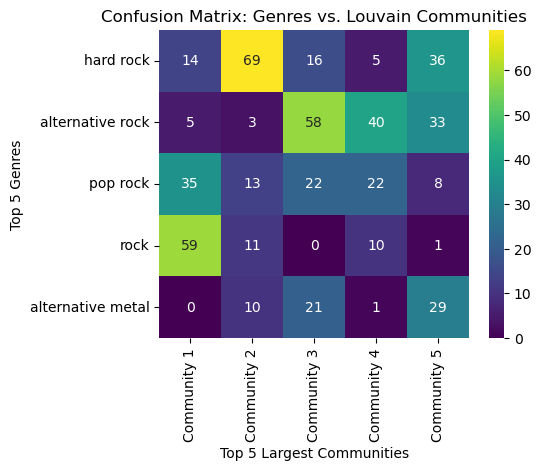

In [ ]:
import seaborn as sns
import numpy as np

# Identify the 5 most common genres - Using all genres associated with each node
all_genres_list = []
for node, data in G.nodes(data=True):
    if 'genres' in data:
        all_genres_list.extend(data['genres'])

genre_counts = Counter(all_genres_list)
top_5_genres = [genre for genre, count in genre_counts.most_common(5)]
top_5_genres_set = set(top_5_genres)


# Identify the 5 largest communities
louvain_communities.sort(key=len, reverse=True)
top_5_communities = louvain_communities[:5]

# Create a set of all nodes that are in one of the top 5 communities
nodes_in_top_communities = set()
for community in top_5_communities:
    nodes_in_top_communities.update(community)


genre_to_idx = {genre: i for i, genre in enumerate(top_5_genres)}
# Map each node to its community index (1-5)
node_to_community_idx = {}
for i, community in enumerate(top_5_communities):
    for node in community:
        node_to_community_idx[node] = i


# Confusion matrix
confusion_matrix = np.zeros((5, 5), dtype=int)

# Iterate through all nodes in the graph that are in the top communities
for node in nodes_in_top_communities:
    # Check if the node has genre data
    if 'genres' in G.nodes[node]:
        node_genres = G.nodes[node]['genres']
        
        # Find which of the top 5 genres this node has
        relevant_genres = top_5_genres_set.intersection(node_genres)
        
        # If the node has at least one of the top 5 genre
        if relevant_genres:
            community_idx = node_to_community_idx[node]
            
            for genre in relevant_genres:
                genre_idx = genre_to_idx[genre]
                confusion_matrix[genre_idx, community_idx] += 1


# Visualize
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='viridis',
            xticklabels=[f'Community {i+1}' for i in range(5)],
            yticklabels=top_5_genres)
plt.title('Confusion Matrix: Genres vs. Louvain Communities')
plt.ylabel(f'Top {5} Genres')
plt.xlabel(f'Top {5} Largest Communities')
plt.show()

**Use the confusion matrix to explain how well the communities you've detected correspond to the genres.**
The louvain network has "only" produced 6 communities, so it has not been possible to take the top 7 genres and communities. We have chosen to look at the top 5 communities and also the top 5 genres.

The rows of the matrix are the top‑5 genres in the entire network and the columns are the top-5 largest Louvain communities (out of the 6 we found). Each cell (i,j) in the confusion matrix is the number of nodes in community j that have genre i, where each band can have multiple genres. A lighter yellow color represents more bands falling into this cell and a darker the opposite. Therefore a yellow color means that many bands in Louvain community j have genre i among their listed genres.

For the genres and communities to be well alligned, every column needs to have only one standout high-value cell. This would mean that Louvain communities aligns well with the genres of the bands/nodes. If columns show several similar counts, the community is mixed across genres. We can see that community 2 and the 'hard rock' genre aligns; $\frac{69}{69+3+13+11+10}\sim65$% of community 2 consists of bands that have hard rock as one of their genres. On the contrary community 5 has a wider spread genre mix, where both 'hard rock, 'alternative rock' and 'alternative metal' are highly represented.

There is a large value in a row 'rock', community 1, and low numbers in the rest of the columns representing the communities. This means that almost all band that have rock genre fall into this community. If the row’s counts are spread across many columns, that genre is diffuse across multiple communities which is the case for 'pop-rock' for instance.

We were asked to count every genre of the bands; This means that each band might be represented in the matrix more than once. Therefore column totals can exceed the number of bands. This makes it more difficult to make analysis, as the same band might be represented in multiple rows.

It should be noted that it might have been a good idea to make an umbrella category called Rock-genres, which constituded of all the rock under categories. This would make the top 4 genres into one single genre, and might make the conclusions different. We have chosen to keep the genres seperate.




-----

#  Part 3: Words that characterize pages or groups of pages
**Exercise: Comparing in the different genres.**

- Setup. You'll need to go to your archives and find the wikipedia pages of all the rock artists.

- Once you have the texts ready, you will want to aggregate the text into 15 long lists, one for each of the top 15 genres (let's call them 15 documents). Each document contains on all the text in that genre (so for the rock genre it's a looooong big doc). In each list, you should keep all the words (or tokens to be more precise) that occur on the pages, and a count of how frequently each word occurs. So the format should be:

word0 count0

word1 count1

word2 count2

- This list is called a Term Frequency (or TF) list for each genre. Let's build our own TF lists. Before you start counting, I am going to ask you do do a few things



In [ ]:
# getting the pages with text


**Action items**

- Tokenize the pages into one long string per genre
- Remove all punctuation from your list of tokens
- Set everything to lower case
- (Optional) Lemmatize your words
- It's a good idea to filter out rare words (e.g. words that only appear less than 5 times).